<h1>Analysis on Insurance Costs of U.S. Adults</h1>

The dataset of the insurance costs of U.S. adults is composed of 7 columns, with 6 independent variables (<b>age, sex, bmi, child, smoker, region</b>) and 1 outcome variable (<b>charges</b>). In prior to the profound analysis of the relationship between these variables, I will briefly summarize an important detail of this dataset.


In this dataset, the <b>median</b> insurance charge is approximately <b>9382.03</b>, and the <b>mean</b> insurance charge is approximately  <b>13270.42</b>, which is 41.44% higher than the former. Looking at the histogram, we can clearly see that the distribution is <i>skewed to the right</i>. In order to account for the skewedness of the distribution, I will <b>use median instead of mean</b> to evaluate the center of certain distributions when analyzing the relationships between different variables.

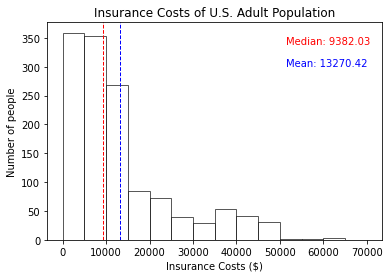

<Figure size 432x288 with 0 Axes>

In [98]:
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt

insurances = pd.read_csv('insurance.csv')

plt.hist(insurances.charges, range=(0, 70000), bins=14, edgecolor='k', alpha=0.65, color='white')
plt.title('Insurance Costs of U.S. Adult Population')
plt.xlabel('Insurance Costs ($)')
plt.ylabel('Number of people')

plt.axvline(charges_mean, color='b', linestyle='dashed', linewidth=1)
plt.axvline(charges_median, color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.7, max_ylim * 0.8, f'Mean: {round(insurances.charges.mean(), 2)}', color='b')
plt.text(max_xlim*0.7, max_ylim * 0.9, f'Median: {round(insurances.charges.median(),2)}', color='r')

plt.show()
plt.clf()


<h3>Part 1: Determine the strongest and the weakest contributing factor to the insurance charges</h3>

In [99]:
# Function that changes the region into an integer
def region_index(x):
	if x == 'southwest':
		return 1
	elif x == 'southeast':
		return 2
	elif x == 'northwest':
		return 3
	else:
		return 4

# Converting the qualitative values into quantitative values for easier computation
insurances['sex'] = insurances.sex.apply(lambda x: 1 if x =="male" else 2)
insurances['smoker'] = insurances.smoker.apply(lambda x: 1 if x =='yes' else 0)
insurances['region'] = insurances.region.apply(lambda x: region_index(x))

#Calculating the correlation coefficient of each variable with the insurance charges
age_charges = insurances['age'].corr(insurances['charges'])
sex_charges = insurances['sex'].corr(insurances['charges'])
bmi_charges = insurances['bmi'].corr(insurances['charges'])
child_charges = insurances['children'].corr(insurances['charges'])
smoker_charges = insurances['smoker'].corr(insurances['charges'])
region_charges = insurances['region'].corr(insurances['charges'])

# Creating a table of variables against the correlation coefficients to easily compare the values
charges_corr_df = pd.DataFrame({'variables': ['age', 'sex', 'bmi', 'child', 'smoker', 'region'], 'corr_coeff': [age_charges, sex_charges, bmi_charges, child_charges, smoker_charges, region_charges]})
print(charges_corr_df)

  variables  corr_coeff
0       age    0.299008
1       sex   -0.057292
2       bmi    0.198341
3     child    0.067998
4    smoker    0.787251
5    region    0.006208


Looking at the table, we could see that the <b>"smoker"</b> variable has the strongest correlation with the insurance charges, and the <b>"region"</b> variable has the weakest (or almost no) correlation with the insurance charges. This contradicts my initial hypothesis that <b>"bmi"</b> would be the largest contributing factor to the insurance charges (<b>"bmi"</b> in fact had a low correlation coefficient value of less than <b>0.2</b>). Although we cannot readily conclude that being a smoker results in a higher insurance charge, it is safe to speculate that <i>smokers tend to pay higher insurance costs compared to non-smokers</i>. 

<h3> Part 2: Determine how the smoking habits in each sex affect the insurance charges </h3>

Let's begin by inspecting the number of smokers and non-smokers in our data, and difference in the median insurance charges between the smokers and non-smokers. 

In [100]:
# Grouping the dataset with "smoker" variable (strongest factor); there are 1064 non-smokers and 274 smokers in our dataset
smokers_charge = insurances.groupby('smoker').charges.median().reset_index()
smokers_number = insurances.groupby('smoker').age.count().reset_index()
smokers_number.rename(columns={'age': 'num_people'}, inplace=True)
smokers_charge = pd.merge(smokers_charge, smokers_number)
print(smokers_charge)

   smoker      charges  num_people
0       0   7345.40530        1064
1       1  34456.34845         274


As the data in the table displays, the median charges of non-smokers is approximately 7345.41 where as that of smokers 34456.35, about 469.09% higher than the former. <i>Smoking seems to be a highly expensive habit in relation to insurance charges. </i> Now, we will divide the participants into four groups, according to their sex and smoking habit, and inspect how the insurance charges across different groups differ.

In [112]:
# Grouping based on the variables "smoker" and "sex"
smokers_sex = insurances.groupby(['smoker', 'sex']).charges.median().reset_index()
smokers_sex['sex'] = smokers_sex['sex'].apply(lambda x: 'male' if x ==1 else 'female')
smokers_sex_pivot = smokers_sex.pivot(columns='smoker', index='sex', values='charges')
smokers_sex_pivot.index.name = None
smokers_sex_pivot.rename(columns={0: 'non-smoker', 1:'smoker'}, inplace=True)
print(smokers_sex_pivot)

smoker  non-smoker      smoker
female  7639.41745  28950.4692
male    6985.50695  36085.2190


The median insurance charges of <b>female non-smokers</b> is 7639.42 and that of <b>female smokers</b> is 28950.50; the median insurance charges of <b>male non-smokers</b> is 6985.51 and that of <b>male smokers</b> is 36085.22. Interestingly enough, smoking habit among the male participants incurred in 29099.71 increase in insurance charges, which is 37% higher than the increase in the insurance charges incurred by the smoking habit of female participants, which is 21311.08. In other words, "smoker" variable affected the insurance charges of the "male" participants <i>37% more</i> than it did to the insurance charges of the "female" participants. This is vindicated by the higher correlation coefficient between "smoker" and "charge" among "male" participants than in "female" participants.

In [114]:
# Grouping based on sex
males = insurances[insurances['sex'] == 1]
females = insurances[insurances['sex'] == 2]
male_corr = males['smoker'].corr(males['charges'])
female_corr = females['smoker'].corr(females['charges'])
m_f_corr = pd.DataFrame({'sex': ['male', 'female'], 'corr': [male_corr, female_corr]})
print(m_f_corr)

      sex      corr
0    male  0.816579
1  female  0.746695
